In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('data/Bakery sales.csv')

## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [4]:
df.iloc[:,0]

0              0
1              1
2              4
3              5
4              8
           ...  
234000    511387
234001    511388
234002    511389
234003    511392
234004    511395
Name: Unnamed: 0, Length: 234005, dtype: int64

In [5]:
df = df.drop(columns = 'Unnamed: 0')

### Formatting columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  object 
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


In [7]:
df['unit_price']

0         0,90 €
1         1,20 €
2         1,20 €
3         1,15 €
4         1,20 €
           ...  
234000    0,15 €
234001    1,20 €
234002    0,15 €
234003    1,30 €
234004    1,30 €
Name: unit_price, Length: 234005, dtype: object

In [8]:
def convert_currency_format(value):
    value = value.replace('€', '')
    value = value.replace(' ', '')
    value = value.replace(',', '.')
    return float(value)

In [9]:
df['unit_price'] = df['unit_price'].astype(str)
df['unit_price'] = df['unit_price'].apply(convert_currency_format)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  float64
dtypes: float64(3), object(3)
memory usage: 10.7+ MB


**Renaming 'Quantity' column to 'quantity'**

In [11]:
df = df.rename(columns={'Quantity': 'quantity'})

In [12]:
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


#### Converting 'date' and 'time' to the appropiate data type, and creating a new 'datetime' column

In [13]:
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           234005 non-null  datetime64[ns]
 1   time           234005 non-null  object        
 2   ticket_number  234005 non-null  float64       
 3   article        234005 non-null  object        
 4   quantity       234005 non-null  float64       
 5   unit_price     234005 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.7+ MB


In [15]:
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


In [16]:
df['time'] = df['time'].astype(str)
df['time'] = df['time'] + ':00'

In [17]:
df['time'] = pd.to_timedelta(df['time'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           234005 non-null  datetime64[ns] 
 1   time           234005 non-null  timedelta64[ns]
 2   ticket_number  234005 non-null  float64        
 3   article        234005 non-null  object         
 4   quantity       234005 non-null  float64        
 5   unit_price     234005 non-null  float64        
dtypes: datetime64[ns](1), float64(3), object(1), timedelta64[ns](1)
memory usage: 10.7+ MB


In [19]:
df['datetime'] = df['date'] + df['time']

In [20]:
df.head()

,date,time,ticket_number,article,quantity,unit_price,datetime
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00


In [21]:
df.describe()

,date,time,ticket_number,quantity,unit_price,datetime
count,234005,234005,234005.000000,234005.000000,234005.000000,234005
mean,2021-11-30 11:33:31.049336576,0 days 11:34:00.873827482,219201.258738,1.538377,1.662195,2021-11-30 23:07:31.923163904
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,-200.000000,0.000000,2021-01-02 08:38:00
25%,2021-07-03 00:00:00,0 days 09:42:00,184754.000000,1.000000,1.100000,2021-07-03 11:21:00
50%,2021-11-04 00:00:00,0 days 11:06:00,218807.000000,1.000000,1.200000,2021-11-04 11:56:00
75%,2022-05-31 00:00:00,0 days 12:21:00,253927.000000,2.000000,1.500000,2022-05-31 09:18:00
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,200.000000,60.000000,2022-09-30 18:56:00
std,NaN,0 days 02:45:25.077746610,40053.223896,1.289603,1.722720,NaN


The "quantity" column has maximum and minimum values of 200 and -200, so we can suspect there are some extreme values in the column.

Text(0.5, 1.0, 'Quantity')

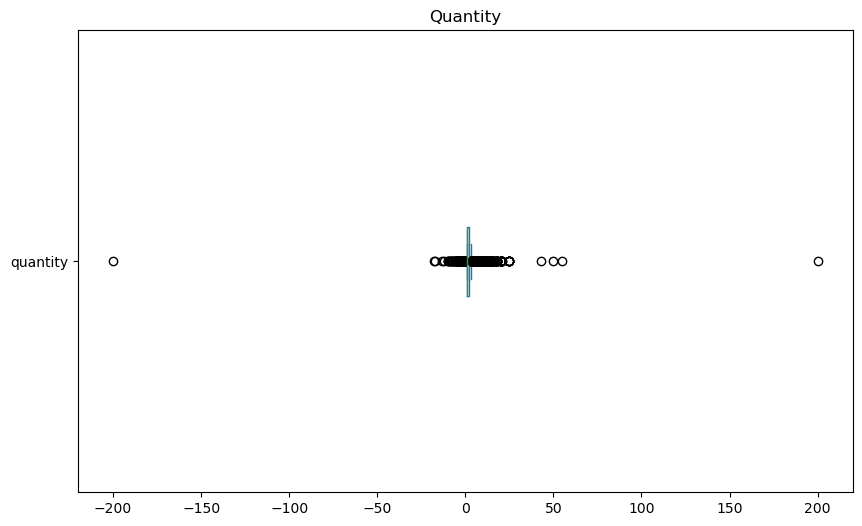

In [22]:
df['quantity'].plot(kind='box', vert=False, figsize=(10,6)).set_title('Quantity')

In [23]:
df[df['quantity'] == 200]

,date,time,ticket_number,article,quantity,unit_price,datetime
50552,2021-06-12,0 days 09:58:00,179931.0,CAFE OU EAU,200.0,1.0,2021-06-12 09:58:00


In [24]:
df[(df['ticket_number'] >= 179931.0) & (df['ticket_number'] < 179933.0)]

,date,time,ticket_number,article,quantity,unit_price,datetime
50552,2021-06-12,0 days 09:58:00,179931.0,CAFE OU EAU,200.0,1.0,2021-06-12 09:58:00
50553,2021-06-12,0 days 09:58:00,179932.0,CAFE OU EAU,-200.0,1.0,2021-06-12 09:58:00


We can observe that this was an error when the quantity was entered, and it was inmediatelly cancelled. These records will be removed from the dataframe.

In [25]:
df = df[(df['quantity'] != 200) & (df['quantity'] != -200)]

Text(0.5, 1.0, 'Quantity')

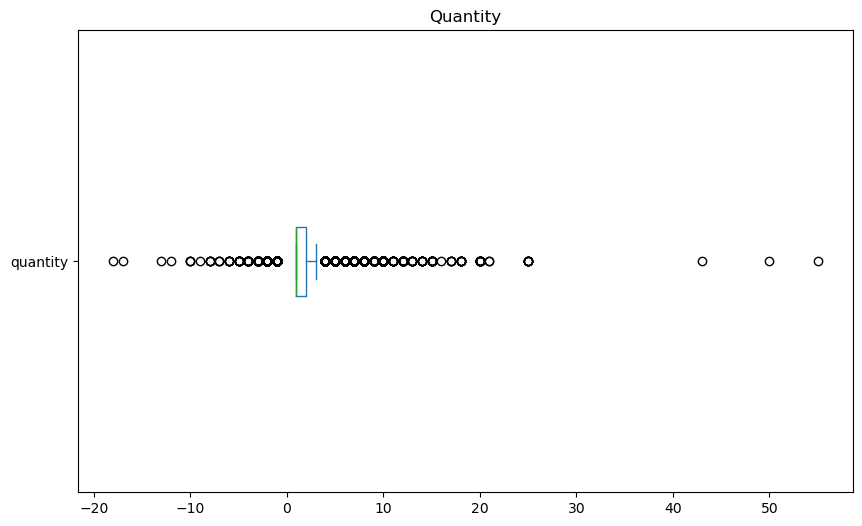

In [26]:
df['quantity'].plot(kind='box', vert=False, figsize=(10,6)).set_title('Quantity')

We still observe values that can be considered outliers, but lets take a closer look first.

In [27]:
df[df['quantity'] > 20]

,date,time,ticket_number,article,quantity,unit_price,datetime
69887,2021-07-23,0 days 11:26:00,191236.0,TARTELETTE,25.0,2.00,2021-07-23 11:26:00
74457,2021-07-30,0 days 17:07:00,193898.0,SEIGLE,25.0,1.80,2021-07-30 17:07:00
74459,2021-07-30,0 days 17:07:00,193898.0,COUPE,25.0,0.15,2021-07-30 17:07:00
89771,2021-08-22,0 days 08:16:00,202518.0,PAIN AU CHOCOLAT,25.0,1.20,2021-08-22 08:16:00
89774,2021-08-22,0 days 08:16:00,202518.0,CROISSANT,25.0,1.10,2021-08-22 08:16:00
111055,2021-10-19,0 days 16:43:00,215345.0,TRADITIONAL BAGUETTE,25.0,1.20,2021-10-19 16:43:00
115245,2021-10-31,0 days 10:42:00,217821.0,TRADITIONAL BAGUETTE,55.0,1.20,2021-10-31 10:42:00
118313,2021-11-08,0 days 10:03:00,219600.0,CAMPAGNE,21.0,1.80,2021-11-08 10:03:00
118314,2021-11-08,0 days 10:03:00,219600.0,COUPE,21.0,0.15,2021-11-08 10:03:00
118315,2021-11-08,0 days 10:03:00,219600.0,BAGUETTE,43.0,0.90,2021-11-08 10:03:00


These seem to be big quantities, but they are reasonable. For example the biggest quantity now is 50, of *PAIN* (bread in English). This could be a customer buying 50 breads for a party or family reunion.

### Checking for duplicates

In [28]:
df.duplicated().sum()

1210

In [29]:
df[df.duplicated(keep=False)]

,date,time,ticket_number,article,quantity,unit_price,datetime
34,2021-01-02,0 days 10:12:00,150061.0,COUPE,1.0,0.15,2021-01-02 10:12:00
36,2021-01-02,0 days 10:12:00,150061.0,COUPE,1.0,0.15,2021-01-02 10:12:00
40,2021-01-02,0 days 10:18:00,150063.0,COUPE,1.0,0.15,2021-01-02 10:18:00
43,2021-01-02,0 days 10:18:00,150063.0,COUPE,1.0,0.15,2021-01-02 10:18:00
218,2021-01-02,0 days 12:23:00,150154.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-02 12:23:00
...,...,...,...,...,...,...,...
233675,2022-09-30,0 days 07:49:00,288719.0,COUPE,1.0,0.15,2022-09-30 07:49:00
233743,2022-09-30,0 days 09:45:00,288757.0,COUPE,1.0,0.15,2022-09-30 09:45:00
233744,2022-09-30,0 days 09:45:00,288757.0,COUPE,1.0,0.15,2022-09-30 09:45:00
233927,2022-09-30,0 days 16:02:00,288867.0,COUPE,1.0,0.15,2022-09-30 16:02:00


1210 duplicates were found, these can be the result of wrong entries by the cashiers or just the same products being marked separately in a purchase. 
These rows will not be removed, let's assume these are products marked separately, since this is a pretty usual thing to happen in stores. 

### Addressing negative values in the quantity column

In [30]:
df[df['quantity'] < 0]

,date,time,ticket_number,article,quantity,unit_price,datetime
448,2021-01-03,0 days 10:41:00,150265.0,BAGUETTE,-1.0,0.90,2021-01-03 10:41:00
1162,2021-01-05,0 days 19:00:00,150738.0,SPECIAL BREAD,-1.0,2.40,2021-01-05 19:00:00
1163,2021-01-05,0 days 19:00:00,150738.0,DIVERS PATISSERIE,-1.0,6.00,2021-01-05 19:00:00
1164,2021-01-05,0 days 19:00:00,150738.0,DIVERS BOULANGERIE,-1.0,2.00,2021-01-05 19:00:00
1467,2021-01-08,0 days 11:58:00,150941.0,COUPE,-1.0,0.15,2021-01-08 11:58:00
...,...,...,...,...,...,...,...
233054,2022-09-27,0 days 18:03:00,288312.0,COUPE,-2.0,0.15,2022-09-27 18:03:00
233055,2022-09-27,0 days 18:03:00,288312.0,TRADITIONAL BAGUETTE,-1.0,1.30,2022-09-27 18:03:00
233056,2022-09-27,0 days 18:03:00,288312.0,CEREAL BAGUETTE,-3.0,1.35,2022-09-27 18:03:00
233553,2022-09-29,0 days 11:55:00,288639.0,BOISSON 33CL,-1.0,1.50,2022-09-29 11:55:00


Negative values in the quantity column were found, this can mean that these transactions were refunds and product returns. We can take a closer look to this records with negative quantities, for example the one at 2021-01-05, SPECIAL BREAD, DIVERS PATISSERIE, and DIVERS BOULANGERIE, with the ticket number of 150738.0

In [31]:
start_time = pd.Timestamp('2021-01-05' + ' 18:40') 
end_time = pd.Timestamp('2021-01-05' + ' 19:00')

df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

,date,time,ticket_number,article,quantity,unit_price,datetime
1156,2021-01-05,0 days 18:49:00,150734.0,BANETTE,2.0,1.05,2021-01-05 18:49:00
1157,2021-01-05,0 days 18:49:00,150735.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-05 18:49:00
1158,2021-01-05,0 days 18:51:00,150736.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-05 18:51:00
1159,2021-01-05,0 days 18:58:00,150737.0,DIVERS PATISSERIE,1.0,6.00,2021-01-05 18:58:00
1160,2021-01-05,0 days 18:58:00,150737.0,DIVERS BOULANGERIE,1.0,2.00,2021-01-05 18:58:00
1161,2021-01-05,0 days 18:58:00,150737.0,SPECIAL BREAD,1.0,2.40,2021-01-05 18:58:00
1162,2021-01-05,0 days 19:00:00,150738.0,SPECIAL BREAD,-1.0,2.40,2021-01-05 19:00:00
1163,2021-01-05,0 days 19:00:00,150738.0,DIVERS PATISSERIE,-1.0,6.00,2021-01-05 19:00:00
1164,2021-01-05,0 days 19:00:00,150738.0,DIVERS BOULANGERIE,-1.0,2.00,2021-01-05 19:00:00
1165,2021-01-05,0 days 19:00:00,150739.0,DIVERS PATISSERIE,1.0,6.00,2021-01-05 19:00:00


We observe that those same three items were bought a couple of minutes before with the ticket number 150737.0, this shows that these negative numbers may represent, in most cases, returns or cancelled purchases.

For the purposes of the analysis, the rows with negative amounts will be kept since they are likely to represent canceled purchases or product returns.

### Checking article names

In [32]:
sorted(df['article'].unique())

['.',
 '12 MACARON',
 'ARMORICAIN',
 'ARTICLE 295',
 'BAGUETTE',
 'BAGUETTE APERO',
 'BAGUETTE GRAINE',
 'BANETTE',
 'BANETTINE',
 'BOISSON 33CL',
 'BOTTEREAU',
 'BOULE 200G',
 'BOULE 400G',
 'BOULE POLKA',
 'BRIOCHE',
 'BRIOCHE DE NOEL',
 'BRIOCHETTE',
 'BROWNIES',
 'BUCHE 4PERS',
 'BUCHE 6PERS',
 'BUCHE 8PERS',
 'CAFE OU EAU',
 'CAKE',
 'CAMPAGNE',
 'CARAMEL NOIX',
 'CEREAL BAGUETTE',
 'CHAUSSON AUX POMMES',
 'CHOCOLAT',
 'CHOU CHANTILLY',
 'COMPLET',
 'COOKIE',
 'COUPE',
 'CROISSANT',
 'CROISSANT AMANDES',
 'CRUMBLE',
 'CRUMBLECARAMEL OU PISTAE',
 'DELICETROPICAL',
 'DEMI BAGUETTE',
 'DEMI PAIN',
 'DIVERS BOISSONS',
 'DIVERS BOULANGERIE',
 'DIVERS CONFISERIE',
 'DIVERS PATISSERIE',
 'DIVERS SANDWICHS',
 'DIVERS VIENNOISERIE',
 'DOUCEUR D HIVER',
 'ECLAIR',
 'ECLAIR FRAISE PISTACHE',
 'ENTREMETS',
 'FICELLE',
 'FINANCIER',
 'FINANCIER X5',
 'FLAN',
 'FLAN ABRICOT',
 'FONDANT CHOCOLAT',
 'FORMULE PATE',
 'FORMULE PLAT PREPARE',
 'FORMULE SANDWICH',
 'FRAISIER',
 'FRAMBOISIER',
 'GACHE

There is an article named '.'

In [33]:
df[df['article'] == '.']

,date,time,ticket_number,article,quantity,unit_price,datetime
15360,2021-03-04,0 days 12:32:00,159219.0,.,2.0,0.0,2021-03-04 12:32:00
19904,2021-03-18,0 days 12:59:00,161853.0,.,1.0,0.0,2021-03-18 12:59:00
24959,2021-04-04,0 days 09:53:00,164878.0,.,1.0,0.0,2021-04-04 09:53:00
33569,2021-04-27,0 days 16:48:00,170079.0,.,1.0,0.0,2021-04-27 16:48:00
61792,2021-07-10,0 days 13:25:00,186662.0,.,2.0,0.0,2021-07-10 13:25:00


There are five if these "." articles, it's not clear what they represent. Since they are just five, and all of their unit prices are 0 they will be removed.

In [34]:
df = df[df['article'] != '.']

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233998 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           233998 non-null  datetime64[ns] 
 1   time           233998 non-null  timedelta64[ns]
 2   ticket_number  233998 non-null  float64        
 3   article        233998 non-null  object         
 4   quantity       233998 non-null  float64        
 5   unit_price     233998 non-null  float64        
 6   datetime       233998 non-null  datetime64[ns] 
dtypes: datetime64[ns](2), float64(3), object(1), timedelta64[ns](1)
memory usage: 14.3+ MB


# Analysis

**Adding a "total" column**:

In [36]:
df['total'] = df['quantity'] * df['unit_price']

In [37]:
df.head()

,date,time,ticket_number,article,quantity,unit_price,datetime,total
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00,0.90
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00,1.15
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00


## Total sales

In [38]:
total_sales = df['total'].sum()
total_sales

558640.8499999999

## Sales Over Time

In [65]:
df['month'] = df['datetime'].dt.to_period('M')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233998 entries, 0 to 234004
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           233998 non-null  datetime64[ns] 
 1   time           233998 non-null  timedelta64[ns]
 2   ticket_number  233998 non-null  float64        
 3   article        233998 non-null  object         
 4   quantity       233998 non-null  float64        
 5   unit_price     233998 non-null  float64        
 6   datetime       233998 non-null  datetime64[ns] 
 7   total          233998 non-null  float64        
 8   month          233998 non-null  period[M]      
dtypes: datetime64[ns](2), float64(4), object(1), period[M](1), timedelta64[ns](1)
memory usage: 17.9+ MB


In [63]:
sales_over_time = df.groupby('date')['total'].sum().reset_index()
sales_over_time

,date,total
0,2021-01-02,987.85
1,2021-01-03,1014.30
2,2021-01-04,461.90
3,2021-01-05,515.70
4,2021-01-07,544.00
...,...,...
595,2022-09-26,693.75
596,2022-09-27,746.45
597,2022-09-28,610.70
598,2022-09-29,689.20


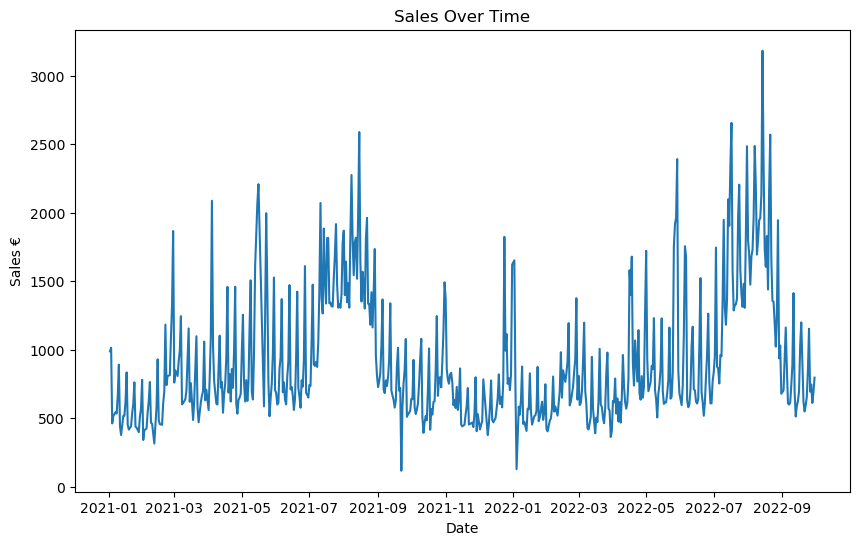

In [60]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_over_time, x='date', y='total')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales €')
plt.show()

### Sales by Month

In [66]:
sales_by_month = df.groupby('month')['total'].sum().reset_index()
sales_by_month

,month,total
0,2021-01,15258.67
1,2021-02,16827.15
2,2021-03,20087.60
3,2021-04,24649.75
4,2021-05,29617.25
5,2021-06,24610.25
6,2021-07,42201.45
7,2021-08,48680.35
8,2021-09,22728.80
9,2021-10,22704.35


In [70]:
sales_by_month['month'] = sales_by_month['month'].dt.strftime('%b %Y')

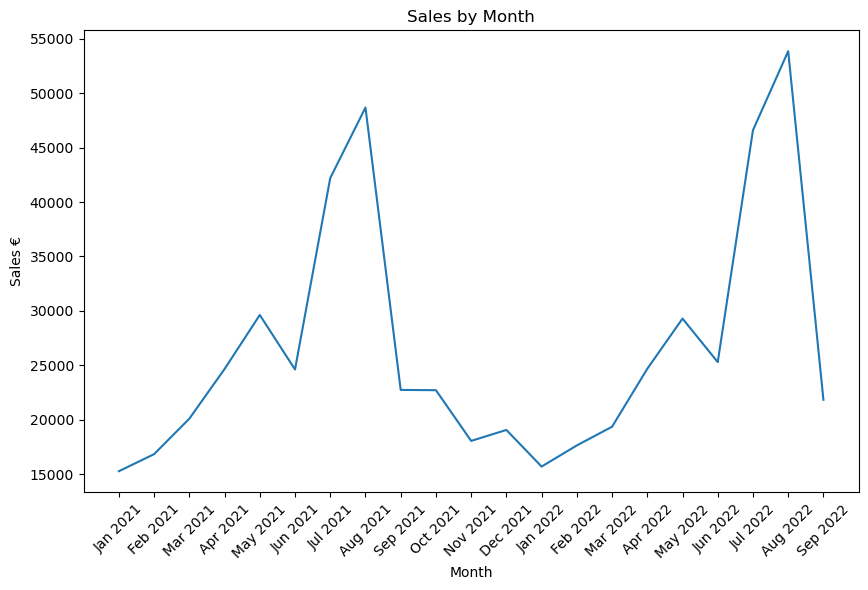

In [72]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_by_month, x='month', y='total')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales €')
plt.xticks(rotation=45)
plt.show()

### Sales by Day of Week

In [73]:
df['day_of_week'] = df['date'].dt.dayofweek

day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df['day_name'] = df['day_of_week'].map(day_names)

In [77]:
sales_by_day = df.groupby('day_name')['total'].sum().reset_index()
sales_by_day

,day_name,total
0,Friday,77063.37
1,Monday,73949.65
2,Saturday,93733.72
3,Sunday,126339.88
4,Thursday,70150.88
5,Tuesday,67291.30
6,Wednesday,50112.05


In [78]:
sales_by_day['day_name'] = pd.Categorical(sales_by_day['day_name'], 
                                          categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                      'Friday', 'Saturday', 'Sunday'], 
                                          ordered=True)
sales_by_day = sales_by_day.sort_values('day_name')

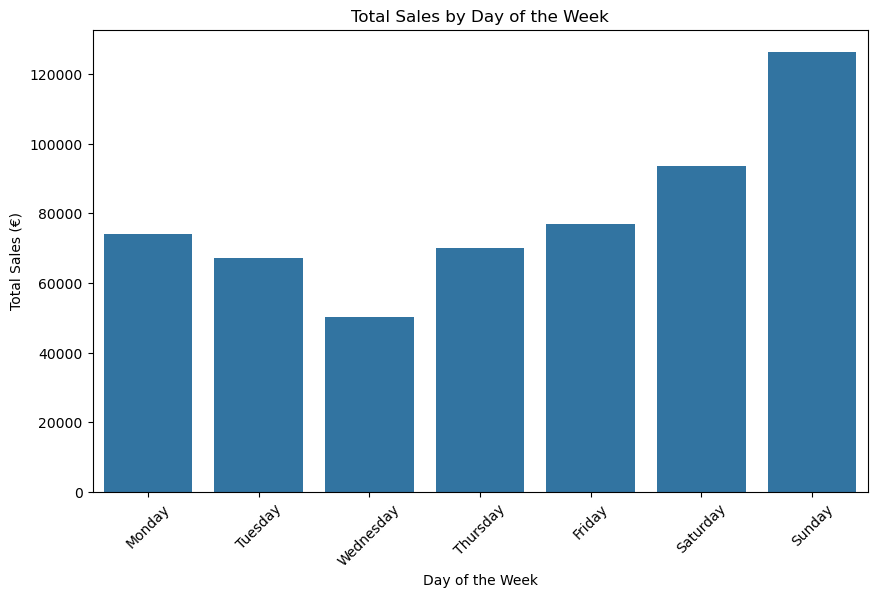

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_day, x='day_name', y='total')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales (€)')
plt.xticks(rotation=45)
plt.show()

## Best selling products

In [39]:
sales_by_product = df.groupby('article')['total'].sum().reset_index().set_index('article').sort_values(by='total', ascending=False)
sales_by_product

,total
article,
TRADITIONAL BAGUETTE,144756.05
FORMULE SANDWICH,34710.50
CROISSANT,33579.50
PAIN AU CHOCOLAT,31100.45
BANETTE,24555.15
...,...
TROIS CHOCOLAT,3.00
CAKE,3.00
PAIN NOIR,0.60


### Top 10 best selling products

In [40]:
sales_by_product.head(10)

,total
article,
TRADITIONAL BAGUETTE,144756.05
FORMULE SANDWICH,34710.50
CROISSANT,33579.50
PAIN AU CHOCOLAT,31100.45
BANETTE,24555.15
BAGUETTE,20481.40
SANDWICH COMPLET,13550.00
SPECIAL BREAD,13419.70
TRAITEUR,12254.30


<Axes: title={'center': 'Top 10 best selling products'}, xlabel='article'>

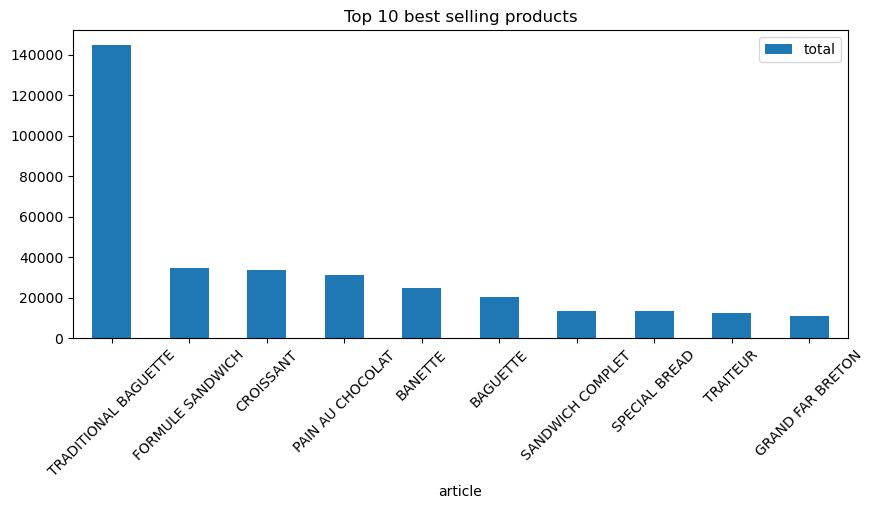

In [41]:
sales_by_product.head(10).plot(kind="bar", figsize=(10,4),title="Top 10 best selling products", rot=45)

By seeing the top 10 best selling products, it's clear that the "Traditional Baguette" is by far the best selling product with more than 140,000 Euros in sales, followed by the "Formule Sandwich" with total sales of 34710.50 Euros.

## Top products by quantity sold

In [42]:
quantity_sold = df.groupby('article')['quantity'].sum().reset_index().set_index('article').sort_values(by='quantity', ascending=False)
quantity_sold

,quantity
article,
TRADITIONAL BAGUETTE,117463.0
CROISSANT,29654.0
PAIN AU CHOCOLAT,25236.0
COUPE,23505.0
BANETTE,22732.0
...,...
REDUCTION SUCREES 24,1.0
DOUCEUR D HIVER,1.0
PAIN NOIR,1.0


### Top 10 products by quantity sold

In [43]:
top_ten_quantity = quantity_sold.head(10)
top_ten_quantity

,quantity
article,
TRADITIONAL BAGUETTE,117463.0
CROISSANT,29654.0
PAIN AU CHOCOLAT,25236.0
COUPE,23505.0
BANETTE,22732.0
BAGUETTE,22053.0
CEREAL BAGUETTE,7427.0
SPECIAL BREAD,5456.0
FORMULE SANDWICH,5181.0


<Axes: title={'center': 'Top 10 products by quantity'}, xlabel='article'>

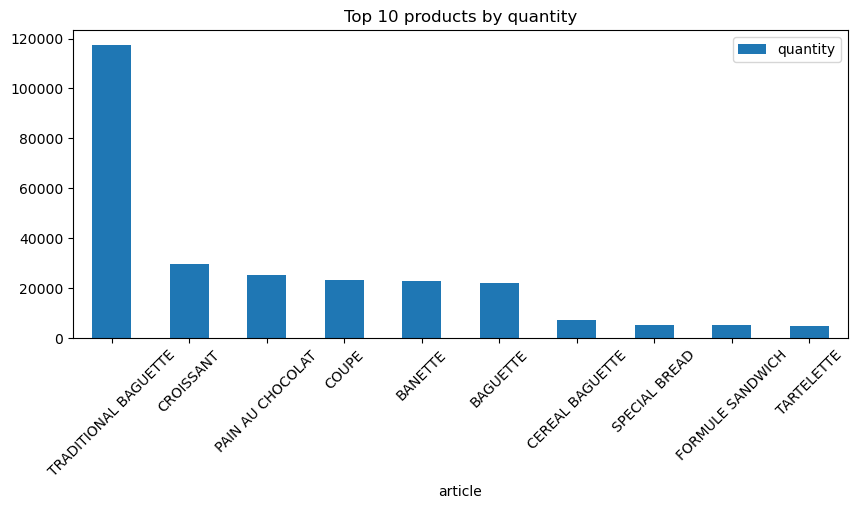

In [44]:
top_ten_quantity.plot(kind="bar", figsize=(10,4),title="Top 10 products by quantity", rot=45)

When it comes to quantity sold, "Traditional Baguettes" is still on top with 117,463 units sold, followed by the "Croissant" with 29,654 units.

## Low-Performing Products

In [45]:
lowest_sales = df.groupby('article')['total'].sum().reset_index().set_index('article').sort_values(by='total')
lowest_sales

,total
article,
ARTICLE 295,0.00
PLAT 6.50E,0.00
PAIN NOIR,0.60
DOUCEUR D HIVER,3.00
TROIS CHOCOLAT,3.00
...,...
BANETTE,24555.15
PAIN AU CHOCOLAT,31100.45
CROISSANT,33579.50


In [46]:
lowest_sales.head(20)

,total
article,
ARTICLE 295,0.0
PLAT 6.50E,0.0
PAIN NOIR,0.6
DOUCEUR D HIVER,3.0
TROIS CHOCOLAT,3.0
CAKE,3.0
SACHET DE VIENNOISERIE,4.0
"PLATPREPARE6,00",6.0
PALMIER,6.0


In [47]:
lowest_quantity = df.groupby('article')['quantity'].sum().reset_index().set_index('article').sort_values(by='quantity')
lowest_quantity

,quantity
article,
PLAT 6.50E,0.0
"PLATPREPARE6,00",1.0
DOUCEUR D HIVER,1.0
ARTICLE 295,1.0
PAIN NOIR,1.0
...,...
BANETTE,22732.0
COUPE,23505.0
PAIN AU CHOCOLAT,25236.0


In [48]:
lowest_quantity.head(20)

,quantity
article,
PLAT 6.50E,0.0
"PLATPREPARE6,00",1.0
DOUCEUR D HIVER,1.0
ARTICLE 295,1.0
PAIN NOIR,1.0
TROIS CHOCOLAT,1.0
CAKE,1.0
SACHET DE VIENNOISERIE,1.0
REDUCTION SUCREES 24,1.0


In [49]:
sales_by_product['sales_category'] = pd.qcut(
    sales_by_product['total'], 
    q=[0, 0.2, 0.8, 1.0], 
    labels=['Low-Seller', 'Mid-Tier', 'Top-Seller']
)

In [50]:
sales_by_product.head(50)

,total,sales_category
article,,
TRADITIONAL BAGUETTE,144756.05,Top-Seller
FORMULE SANDWICH,34710.50,Top-Seller
CROISSANT,33579.50,Top-Seller
PAIN AU CHOCOLAT,31100.45,Top-Seller
BANETTE,24555.15,Top-Seller
BAGUETTE,20481.40,Top-Seller
SANDWICH COMPLET,13550.00,Top-Seller
SPECIAL BREAD,13419.70,Top-Seller
TRAITEUR,12254.30,Top-Seller


# Analyzing best selling products

In [51]:
best_selling_names = sales_by_product.head(10).index.to_list()
best_selling_names

['TRADITIONAL BAGUETTE',
 'FORMULE SANDWICH',
 'CROISSANT',
 'PAIN AU CHOCOLAT',
 'BANETTE',
 'BAGUETTE',
 'SANDWICH COMPLET',
 'SPECIAL BREAD',
 'TRAITEUR',
 'GRAND FAR BRETON']

In [52]:
best_selling_data = df[df['article'].isin(best_selling_names)]
best_selling_data

,date,time,ticket_number,article,quantity,unit_price,datetime,total
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.9,2021-01-02 08:38:00,0.9
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.2,2021-01-02 08:38:00,3.6
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.2,2021-01-02 09:14:00,2.4
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.2,2021-01-02 09:25:00,6.0
5,2021-01-02,0 days 09:25:00,150043.0,BAGUETTE,2.0,0.9,2021-01-02 09:25:00,1.8
...,...,...,...,...,...,...,...,...
233993,2022-09-30,0 days 18:26:00,288905.0,TRADITIONAL BAGUETTE,1.0,1.3,2022-09-30 18:26:00,1.3
233997,2022-09-30,0 days 18:39:00,288910.0,TRADITIONAL BAGUETTE,1.0,1.3,2022-09-30 18:39:00,1.3
233999,2022-09-30,0 days 18:52:00,288911.0,TRADITIONAL BAGUETTE,5.0,1.3,2022-09-30 18:52:00,6.5
234003,2022-09-30,0 days 18:55:00,288912.0,TRADITIONAL BAGUETTE,1.0,1.3,2022-09-30 18:55:00,1.3


### Sales over time

In [53]:
sales_over_time = best_selling_data.groupby(['date', 'article'])['total'].sum().reset_index()
sales_over_time

,date,article,total
0,2021-01-02,BAGUETTE,41.4
1,2021-01-02,BANETTE,42.0
2,2021-01-02,CROISSANT,72.6
3,2021-01-02,GRAND FAR BRETON,42.0
4,2021-01-02,PAIN AU CHOCOLAT,57.6
...,...,...,...
5381,2022-09-30,GRAND FAR BRETON,22.5
5382,2022-09-30,PAIN AU CHOCOLAT,41.6
5383,2022-09-30,SANDWICH COMPLET,5.0
5384,2022-09-30,SPECIAL BREAD,26.0


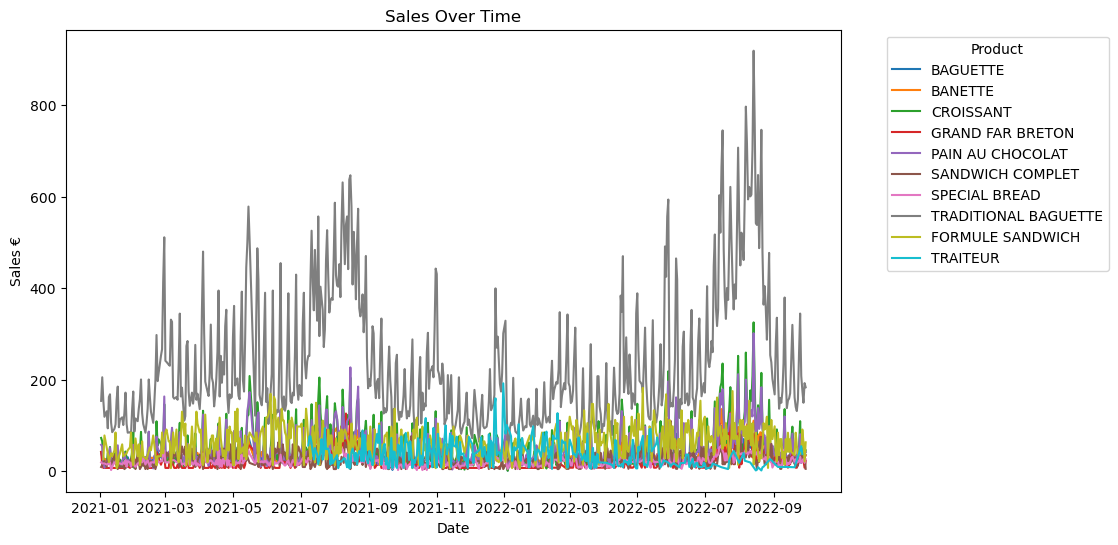

In [54]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_over_time, x='date', y='total', hue='article')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales €')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Sales by month

In [56]:
best_selling_data['month'] = best_selling_data['datetime'].dt.to_period('M')
best_selling_data.head()

C:\Users\feder\AppData\Local\Temp\ipykernel_12304\2157696052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_selling_data['month'] = best_selling_data['datetime'].dt.to_period('M')


,date,time,ticket_number,article,quantity,unit_price,datetime,total,month
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.9,2021-01-02 08:38:00,0.9,2021-01
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.2,2021-01-02 08:38:00,3.6,2021-01
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.2,2021-01-02 09:14:00,2.4,2021-01
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.2,2021-01-02 09:25:00,6.0,2021-01
5,2021-01-02,0 days 09:25:00,150043.0,BAGUETTE,2.0,0.9,2021-01-02 09:25:00,1.8,2021-01
